In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    BertPreTrainedModel, 
    TrainingArguments, 
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# GroupShuffleSplit をインポート
from sklearn.model_selection import GroupShuffleSplit
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# CUDAのデバッグ用
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA RTX A6000


In [2]:
# --- 2. 設定 (本番用) ---

TRAINING_FILE = "data/processed/training_dataset_abstract_cleaned_v3.csv"
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"
OUTPUT_MODEL_DIR = "models/sbert_contrastive_v3"

# --- 実験計画からのハイパーパラメータ ---
MAX_LENGTH = 512
LEARNING_RATE = 2e-5
CONTRASTIVE_MARGIN = 1.0  
BATCH_SIZE = 32
EPOCHS = 3
METRICS_THRESHOLD = 0.5

print(f"Configuration set for Contrastive Loss (Group Split)")

Configuration set for Contrastive Loss (Group Split)


In [3]:
# --- 3. カスタムモデルクラスの定義 (CLS Pooling) ---

class SiameseContrastiveModel(BertPreTrainedModel):
    def __init__(self, config):
        super(SiameseContrastiveModel, self).__init__(config)
        self.bert = AutoModel.from_config(config)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        input_ids_b=None, 
        attention_mask_b=None,
        labels=None,
        **kwargs
    ):
        output_a = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output_b = self.bert(input_ids=input_ids_b, attention_mask=attention_mask_b)

        vec_x = output_a.pooler_output
        vec_y = output_b.pooler_output

        return SequenceClassifierOutput(
            loss=None,
            logits=(vec_x, vec_y), 
            hidden_states=None,
            attentions=None,
        )

print("Custom model class 'SiameseContrastiveModel' (CLS Pooling) defined.")

Custom model class 'SiameseContrastiveModel' (CLS Pooling) defined.


In [4]:
# --- 4. データロード, GroupSplit, トークナイズ ---
print(f"Loading dataset: {TRAINING_FILE}")
df_full = pd.read_csv(TRAINING_FILE)
df_full = df_full.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df_full['label'] = df_full['label'].astype(int)
print(f"Full dataset size: {len(df_full)}")

# --- GroupShuffleSplit の実装 ---
print("Performing Group Shuffle Split based on 'abstract_a'...")
groups = df_full['abstract_a']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df_full, groups=groups))

train_df = df_full.iloc[train_idx]
val_df = df_full.iloc[val_idx]

print(f"Train set: {len(train_df)} pairs")
print(f"Validation set: {len(val_df)} pairs")

# データリーク（重複アンカー）がないか確認
train_anchors = set(train_df['abstract_a'])
val_anchors = set(val_df['abstract_a'])
leakage = train_anchors.intersection(val_anchors)
print(f"Data Leakage Check (Anchor Overlap): {len(leakage)} anchors")
# --- -------------------------- ---

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df)
})
print(f"Dataset split: {dataset}")

# --- トークナイズ処理 ---
print("Initializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_siamese_function(examples):
    tokenized_a = tokenizer(examples["abstract_a"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    tokenized_b = tokenizer(examples["abstract_b"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    return {
        "input_ids": tokenized_a["input_ids"],
        "attention_mask": tokenized_a["attention_mask"],
        "input_ids_b": tokenized_b["input_ids"],
        "attention_mask_b": tokenized_b["attention_mask"],
    }

print("Tokenizing dataset for Siamese model...")
tokenized_datasets = dataset.map(
    tokenize_siamese_function, 
    batched=True, 
    num_proc=4,
    remove_columns=["abstract_a", "abstract_b", "data_paper_doi"]
)

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

Loading dataset: data/processed/training_dataset_abstract_cleaned_v3.csv
Full dataset size: 34624
Performing Group Shuffle Split based on 'abstract_a'...
Train set: 27208 pairs
Validation set: 7416 pairs
Data Leakage Check (Anchor Overlap): 0 anchors
Dataset split: DatasetDict({
    train: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi', '__index_level_0__'],
        num_rows: 27208
    })
    validation: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi', '__index_level_0__'],
        num_rows: 7416
    })
})
Initializing tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing dataset for Siamese model...


Map (num_proc=4):   0%|          | 0/27208 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7416 [00:00<?, ? examples/s]

Tokenization complete.


In [5]:
# --- 5. カスタムTrainerの定義 ---

class ContrastiveTrainer(Trainer):
    def __init__(self, *args, margin=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.margin = margin
        print(f"ContrastiveTrainer initialized with margin={self.margin}")

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        vec_x, vec_y = outputs.logits
        
        distance = F.pairwise_distance(vec_x, vec_y)
        
        loss_positive = distance.pow(2)
        loss_negative = F.relu(self.margin - distance).pow(2)
        
        # ▼▼▼ 修正点: 重み付け (pos_weight) を削除 ▼▼▼
        loss = (labels.float() * loss_positive) + ((1 - labels.float()) * loss_negative)
        
        loss = loss.mean()

        return (loss, outputs) if return_outputs else loss

print("Custom 'ContrastiveTrainer' defined.")

Custom 'ContrastiveTrainer' defined.


In [6]:
# --- 6. モデルのロードと訓練設定 ---
print(f"Loading custom model: {MODEL_CHECKPOINT}")
model = SiameseContrastiveModel.from_pretrained(MODEL_CHECKPOINT, num_labels=2).to(device)
print("Custom model loaded.")

def compute_metrics(eval_pred):
    vec_x, vec_y = eval_pred.predictions
    labels = eval_pred.label_ids
    
    distance = F.pairwise_distance(torch.tensor(vec_x), torch.tensor(vec_y))
    preds = (distance < METRICS_THRESHOLD).int()
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, # 128
    per_device_eval_batch_size=BATCH_SIZE, # 128
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    
    # ▼▼▼ 修正点: ログの戦略を "steps" にし、頻度を細かくする ▼▼▼
    logging_strategy="steps",    # "epoch" から "steps" に変更
    logging_steps=10,            # 100ステップごと -> 10ステップごと
    # ▲▲▲ ------------------------------------------ ▲▲▲
    
    warmup_ratio=0.1,
)
print("Training arguments set.")

Loading custom model: allenai/scibert_scivocab_uncased
Custom model loaded.
Training arguments set.


In [7]:
# --- 7. 訓練の開始 ---
trainer = ContrastiveTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    # tokenizerは不要
    compute_metrics=compute_metrics,
    margin=CONTRASTIVE_MARGIN
    # ▼▼▼ 修正点: pos_weight を削除 ▼▼▼
)

print("\n--- Starting Model Training (Contrastive Loss) ---")
trainer.train()
print("--- Model Training Complete ---")

ContrastiveTrainer initialized with margin=1.0

--- Starting Model Training (Contrastive Loss) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.023400,0.019197,0.978695,0.947193,0.951007,0.943409
2,0.008600,0.015235,0.981392,0.954515,0.945170,0.964048
3,0.007400,0.011467,0.984898,0.963085,0.953655,0.972703


--- Model Training Complete ---


In [8]:
# --- 8. モデルの保存 ---
print("Training complete. Saving best model...")
best_model_path = os.path.join(OUTPUT_MODEL_DIR, "best_model")
trainer.save_model(best_model_path)
print(f"Model saved to {best_model_path}")

Training complete. Saving best model...
Model saved to models/sbert_contrastive_v3/best_model



--- Visualizing Training Results ---


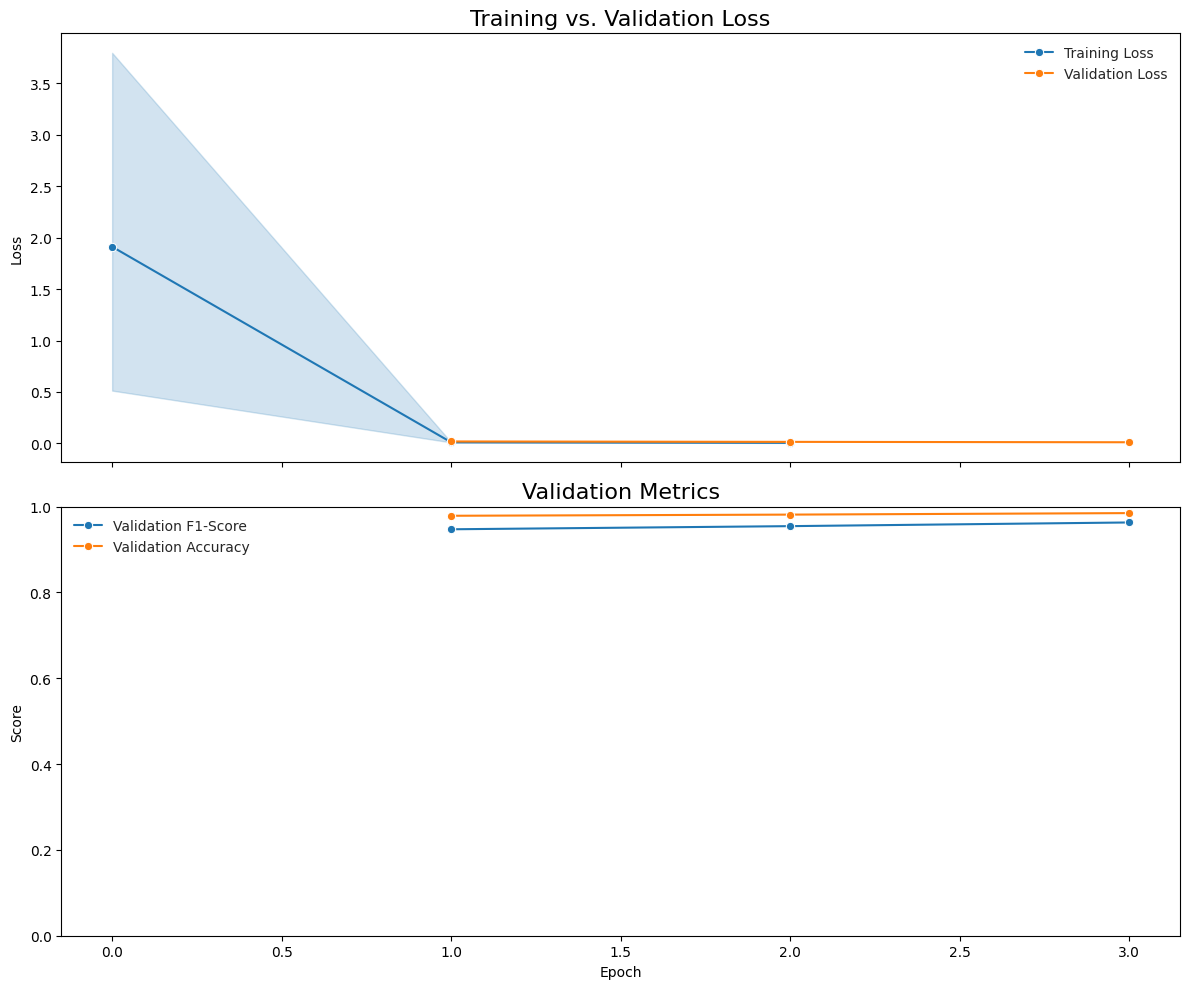


--- Best Model Evaluation Metrics (from validation set) ---
Best Epoch (based on min eval_loss): 3.0
Best Validation Loss: 0.0115
Best Validation F1: 0.9631
Best Validation Accuracy: 0.9849


In [9]:
# --- 9. 訓練結果の可視化 ---
print("\n--- Visualizing Training Results ---")
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy()

if 'epoch' in df_train.columns:
    df_train['epoch'] = df_train['epoch'].astype(int)
if 'epoch' in df_eval.columns:
    df_eval['epoch'] = df_eval['epoch'].astype(int)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

if not df_train.empty:
    sns.lineplot(data=df_train, x='epoch', y='loss', label='Training Loss', ax=ax1, marker='o')
if not df_eval.empty:
    sns.lineplot(data=df_eval, x='epoch', y='eval_loss', label='Validation Loss', ax=ax1, marker='o')
ax1.set_title('Training vs. Validation Loss', fontsize=16)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

if not df_eval.empty:
    sns.lineplot(data=df_eval, x='epoch', y='eval_f1', label='Validation F1-Score', ax=ax2, marker='o')
    sns.lineplot(data=df_eval, x='epoch', y='eval_accuracy', label='Validation Accuracy', ax=ax2, marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_ylabel('Score')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n--- Best Model Evaluation Metrics (from validation set) ---")
if not df_eval.empty:
    best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
    print(f"Best Epoch (based on min eval_loss): {best_run['epoch']}")
    print(f"Best Validation Loss: {best_run['eval_loss']:.4f}")
    print(f"Best Validation F1: {best_run['eval_f1']:.4f}")
    print(f"Best Validation Accuracy: {best_run['eval_accuracy']:.4f}")
else:
    print("No evaluation steps were completed.")